[(0.0, 0.0), (0.14413880565814619, 0.6849992735057776), (0.06314632640648911, 1.3802979275420628), (0.16014457411567376, 2.073544882054917), (0.8167134496905614, 2.316273767081664), (1.4848172197607172, 2.525169320931057), (1.936544892080482, 3.0599048724521496), (2.512547288333698, 3.457675207583558), (2.8768318811511575, 2.859932172964318), (3.326222227148593, 3.218395348861649), (3.5643403927139596, 3.4092176259219986), (3.8942379438016625, 3.7577452959785256), (4.47713846771426, 4.145336548746721), (5.064894789618688, 4.525524010482874), (5.0, 5.0)]


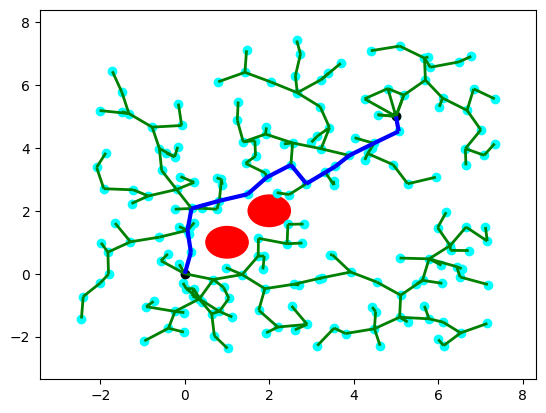

In [4]:

import numpy as np
from random import random
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from collections import deque

class Line():
    def __init__(self, p0, p1):
        self.p = np.array(p0)
        self.dirn = np.array(p1) - np.array(p0)
        self.dist = np.linalg.norm(self.dirn)
        self.dirn /= self.dist # normalize

    def path(self, t):
        return self.p + t * self.dirn


def Intersection(line, center, radius):
    a = np.dot(line.dirn, line.dirn)
    b = 2 * np.dot(line.dirn, line.p - center)
    c = np.dot(line.p - center, line.p - center) - radius * radius

    discriminant = b * b - 4 * a * c
    if discriminant < 0:
        return False

    t1 = (-b + np.sqrt(discriminant)) / (2 * a);
    t2 = (-b - np.sqrt(discriminant)) / (2 * a);

    if (t1 < 0 and t2 < 0) or (t1 > line.dist and t2 > line.dist):
        return False

    return True



def distance(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))


def isInObstacle(vex, obstacles, radius):
    for obs in obstacles:
        if distance(obs, vex) < radius:
            return True
    return False


def isThruObstacle(line, obstacles, radius):
    for obs in obstacles:
        if Intersection(line, obs, radius):
            return True
    return False


def nearest(G, vex, obstacles, radius):
    Nvex = None
    Nidx = None
    minDist = float("inf")

    for idx, v in enumerate(G.vertices):
        line = Line(v, vex)
        if isThruObstacle(line, obstacles, radius):
            continue

        dist = distance(v, vex)
        if dist < minDist:
            minDist = dist
            Nidx = idx
            Nvex = v

    return Nvex, Nidx


def newVertex(randvex, nearvex, stepSize):
    dirn = np.array(randvex) - np.array(nearvex)
    length = np.linalg.norm(dirn)
    dirn = (dirn / length) * min (stepSize, length)

    newvex = (nearvex[0]+dirn[0], nearvex[1]+dirn[1])
    return newvex


def window(startpos, endpos):
    width = endpos[0] - startpos[0]
    height = endpos[1] - startpos[1]
    winx = startpos[0] - (width / 2.)
    winy = startpos[1] - (height / 2.)
    return winx, winy, width, height


def isInWindow(pos, winx, winy, width, height):
    if winx < pos[0] < winx+width and \
        winy < pos[1] < winy+height:
        return True
    else:
        return False


class Graph:
    def __init__(self, startpos, endpos):
        self.startpos = startpos
        self.endpos = endpos

        self.vertices = [startpos]
        self.edges = []
        self.success = False

        self.vex2idx = {startpos:0}
        self.neighbors = {0:[]}
        self.distances = {0:0.}

        self.sx = endpos[0] - startpos[0]
        self.sy = endpos[1] - startpos[1]

    def add_vex(self, pos):
        try:
            idx = self.vex2idx[pos]
        except:
            idx = len(self.vertices)
            self.vertices.append(pos)
            self.vex2idx[pos] = idx
            self.neighbors[idx] = []
        return idx

    def add_edge(self, idx1, idx2, cost):
        self.edges.append((idx1, idx2))
        self.neighbors[idx1].append((idx2, cost))
        self.neighbors[idx2].append((idx1, cost))


    def randomPosition(self):
        rx = random()
        ry = random()

        posx = self.startpos[0] - (self.sx / 2.) + rx * self.sx * 2
        posy = self.startpos[1] - (self.sy / 2.) + ry * self.sy * 2
        return posx, posy


def RRT(startpos, endpos, obstacles, n_iter, radius, stepSize):
    G = Graph(startpos, endpos)

    for _ in range(n_iter):
        randvex = G.randomPosition()
        if isInObstacle(randvex, obstacles, radius):
            continue

        nearvex, nearidx = nearest(G, randvex, obstacles, radius)
        if nearvex is None:
            continue

        newvex = newVertex(randvex, nearvex, stepSize)

        newidx = G.add_vex(newvex)
        dist = distance(newvex, nearvex)
        G.add_edge(newidx, nearidx, dist)

        dist = distance(newvex, G.endpos)
        if dist < 2 * radius:
            endidx = G.add_vex(G.endpos)
            G.add_edge(newidx, endidx, dist)
            G.success = True
            #print('success')
            # break
    return G


def RRT_star(startpos, endpos, obstacles, n_iter, radius, stepSize):
    G = Graph(startpos, endpos)

    for _ in range(n_iter):
        randvex = G.randomPosition()
        if isInObstacle(randvex, obstacles, radius):
            continue

        nearvex, nearidx = nearest(G, randvex, obstacles, radius)
        if nearvex is None:
            continue

        newvex = newVertex(randvex, nearvex, stepSize)

        newidx = G.add_vex(newvex)
        dist = distance(newvex, nearvex)
        G.add_edge(newidx, nearidx, dist)
        G.distances[newidx] = G.distances[nearidx] + dist

        # update nearby vertices distance (if shorter)
        for vex in G.vertices:
            if vex == newvex:
                continue

            dist = distance(vex, newvex)
            if dist > radius:
                continue

            line = Line(vex, newvex)
            if isThruObstacle(line, obstacles, radius):
                continue

            idx = G.vex2idx[vex]
            if G.distances[newidx] + dist < G.distances[idx]:
                G.add_edge(idx, newidx, dist)
                G.distances[idx] = G.distances[newidx] + dist

        dist = distance(newvex, G.endpos)
        if dist < 2 * radius:
            endidx = G.add_vex(G.endpos)
            G.add_edge(newidx, endidx, dist)
            try:
                G.distances[endidx] = min(G.distances[endidx], G.distances[newidx]+dist)
            except:
                G.distances[endidx] = G.distances[newidx]+dist

            G.success = True
            #print('success')
            # break
    return G



def dijkstra(G):
    srcIdx = G.vex2idx[G.startpos]
    dstIdx = G.vex2idx[G.endpos]

    # build dijkstra
    nodes = list(G.neighbors.keys())
    dist = {node: float('inf') for node in nodes}
    prev = {node: None for node in nodes}
    dist[srcIdx] = 0

    while nodes:
        curNode = min(nodes, key=lambda node: dist[node])
        nodes.remove(curNode)
        if dist[curNode] == float('inf'):
            break

        for neighbor, cost in G.neighbors[curNode]:
            newCost = dist[curNode] + cost
            if newCost < dist[neighbor]:
                dist[neighbor] = newCost
                prev[neighbor] = curNode

    # retrieve path
    path = deque()
    curNode = dstIdx
    while prev[curNode] is not None:
        path.appendleft(G.vertices[curNode])
        curNode = prev[curNode]
    path.appendleft(G.vertices[curNode])
    return list(path)



def plot(G, obstacles, radius, path=None):
    px = [x for x, y in G.vertices]
    py = [y for x, y in G.vertices]
    fig, ax = plt.subplots()

    for obs in obstacles:
        circle = plt.Circle(obs, radius, color='red')
        ax.add_artist(circle)

    ax.scatter(px, py, c='cyan')
    ax.scatter(G.startpos[0], G.startpos[1], c='black')
    ax.scatter(G.endpos[0], G.endpos[1], c='black')

    lines = [(G.vertices[edge[0]], G.vertices[edge[1]]) for edge in G.edges]
    lc = mc.LineCollection(lines, colors='green', linewidths=2)
    ax.add_collection(lc)

    if path is not None:
        paths = [(path[i], path[i+1]) for i in range(len(path)-1)]
        lc2 = mc.LineCollection(paths, colors='blue', linewidths=3)
        ax.add_collection(lc2)

    ax.autoscale()
    ax.margins(0.1)
    plt.show()


def pathSearch(startpos, endpos, obstacles, n_iter, radius, stepSize):
    G = RRT_star(startpos, endpos, obstacles, n_iter, radius, stepSize)
    if G.success:
        path = dijkstra(G)
        # plot(G, obstacles, radius, path)
        return path


if __name__ == '__main__':
    startpos = (0., 0.)
    endpos = (5., 5.)
    obstacles = [(1., 1.), (2., 2.)]
    n_iter = 200
    radius = 0.5
    stepSize = 0.7

    G = RRT_star(startpos, endpos, obstacles, n_iter, radius, stepSize)
    # G = RRT(startpos, endpos, obstacles, n_iter, radius, stepSize)

    if G.success:
        path = dijkstra(G)
        print(path)
        plot(G, obstacles, radius, path)
    else:
        plot(G, obstacles, radius)